In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import arrow
import os
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

In [2]:
from dataset import KORDataset
from torch.utils.data import DataLoader

SyntaxError: unexpected EOF while parsing (dataset.py, line 94)

In [ ]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--device',type=str,default='cuda:0',help='')
parser.add_argument('--data',type=str,default='./total_solar_weather_pm_2013_2020.npy',help='data path')
parser.add_argument('--batch_size',type=int,default=64,help='batch size')
parser.add_argument('--seq_len',type=int,default=3,help='seq len')

args = parser.parse_args(args=[])

In [4]:
def load_data():
    data = np.load('total_solar_weather_pm_2013_2020.npy', allow_pickle=True)
    return data

In [5]:
data = load_data()

In [4]:
proj_dir = os.getcwd()
conf_fp = os.path.join(proj_dir, 'config.yaml')
with open(conf_fp, encoding='UTF8') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
features_used = [
      "발전률", #FF0000
      "지점",                       
      "기온(°C)", #FF0000
      "강수량(mm)", #FF0000
      "풍속(m/s)", 
      "풍향(16방위)", 
      "습도(%)", 
      "증기압(hPa)", 
      "이슬점온도(°C)", 
      "현지기압(hPa)", 
      "해면기압(hPa)", 
      "일조(hr)", 
      "일사(MJ/m2)", 
      "적설(cm)", 
      "3시간신적설(cm)", 
      "전운량(10분위)", 
      "중하층운량(10분위)", 
      "운형(운형약어)", 
      "최저운고(100m )", 
      "시정(10m)", 
      "지면상태(지면상태코드)", 
      "현상번호(국내식)", 
      "지면온도(°C)", 
      "5cm 지중온도(°C)", 
      "10cm 지중온도(°C)", 
      "20cm 지중온도(°C)", 
      "30cm 지중온도(°C)",
      "지역",                     
      "망",
      "측정소코드",
      "측정소명",
      "측정일시",   #FF0000
      "SO2",
      "CO",
      "O3",
      "NO2",
      "PM10",   #FF0000
      "PM25",
      "주소"
  ]

In [6]:
location_var = config['experiments']['location_used']
weather_var = config['experiments']['features_used']

In [7]:
location_var

['경상대',
 '광양항세방',
 '구미',
 '남동발전_본사사옥',
 '영동',
 '예천',
 '남제주소내',
 '부산복합자재창고',
 '부산복합1단계',
 '부산수처리장',
 '부산신항',
 '부산본부',
 '삼척소내',
 '신인천소내',
 '신인천전망대',
 '신인천해수취수구',
 '영월본부',
 '영월철도부지',
 '위미2리',
 '인천수산정수장',
 '하동공설운동장',
 '하동변전소',
 '하동보건소',
 '하동본부',
 '하동정수장',
 '하동하수처리장',
 '광양항',
 '당진',
 '당진매립장_송악',
 '당진자재창고',
 '동해',
 '수원환경사업소',
 '황금물류센터',
 '세종시폐기물매립장',
 '연성정수장',
 '영암에프원b',
 '대구',
 '신안']

In [3]:
dddata = np.load('busan_incheon_hadong_solarratio_temp_pre_pm_time2d_2013_2020.npy', allow_pickle=True)

In [19]:
data_Busan = dddata[0]
data_Incheon = dddata[1]
data_Hadong = dddata[2]

In [20]:
data_Busan = pd.DataFrame(data_Busan, columns=['Busan_Solar_Ratio', 'Busan_Temp', 'Busan_Precipitation', 'Busan_PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y'])
data_Incheon = pd.DataFrame(data_Incheon, columns=['Incheon_Solar_Ratio', 'Incheon_Temp', 'Incheon_Precipitation', 'Incheon_PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y'])
data_Hadong = pd.DataFrame(data_Hadong, columns=['Hadong_Solar_Ratio', 'Hadong_Temp', 'Hadong_Precipitation', 'Hadong_PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y'])

In [5]:
data_Busan = pd.DataFrame(data_Busan, columns=['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y'])
data_Incheon = pd.DataFrame(data_Incheon, columns=['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y'])
data_Hadong = pd.DataFrame(data_Hadong, columns=['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y'])

In [6]:
data = pd.DataFrame()
# data['time_idx'] = data_Busan.index

In [7]:
data_Busan_new = pd.DataFrame()
data_Busan_new['time_idx'] = data_Busan.index
data_Busan_new['Group'] = 0
# data_Busan_new = data_Busan.iloc[:,0:4]
# data_Busan_new = pd.concat((data_Busan_new, data_Busan), axis=0)
data_Busan_new[['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y']] = data_Busan

In [8]:
data_Incheon_new = pd.DataFrame()
data_Incheon_new['time_idx'] = data_Incheon.index
data_Incheon_new['Group'] = 1
# data_Incheon_new = data_Incheon.iloc[:,0:4]
# data_Incheon_new = pd.concat((data_Incheon_new, data_Incheon), axis=0)
data_Incheon_new[['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y']] = data_Incheon

In [9]:
data_Hadong_new = pd.DataFrame()
data_Hadong_new['time_idx'] = data_Hadong.index
data_Hadong_new['Group'] = 2
# data_Hadong_new = data_Hadong.iloc[:,0:4]
# data_Hadong_new = pd.concat((data_Hadong_new, data_Hadong), axis=0)
data_Hadong_new[['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y']] = data_Hadong

In [10]:
data = pd.concat((data, data_Busan_new), axis=0)
data = pd.concat((data, data_Incheon_new), axis=0)
data = pd.concat((data, data_Hadong_new), axis=0)


In [11]:
data

,time_idx,Group,Solar_Ratio,Temp,Precipitation,PM10,Year_X,Year_Y,Time_X,Time_Y
0,0,0,0.0,-2.3,NaN,40,1.0,0.0,0.965926,0.258819
1,1,0,0.0,-2.4,NaN,39,1.0,0.0,0.866025,0.5
2,2,0,0.0,-2.5,NaN,47,1.0,0.0,0.707107,0.707107
3,3,0,0.0,-2.0,NaN,42,1.0,0.0,0.5,0.866025
4,4,0,0.0,-2.3,NaN,42,1.0,0.0,0.258819,0.965926
...,...,...,...,...,...,...,...,...,...,...
70123,70123,2,0.0,-0.4,NaN,17.0,0.999852,-0.017213,0.5,-0.866025
70124,70124,2,0.0,-0.9,NaN,21.0,0.999852,-0.017213,0.707107,-0.707107
70125,70125,2,0.0,-1.1,NaN,19.0,0.999852,-0.017213,0.866025,-0.5
70126,70126,2,0.0,-0.9,NaN,21.0,0.999852,-0.017213,0.965926,-0.258819


In [55]:
data = pd.DataFrame()

In [56]:
data_Busan_new = pd.DataFrame()
# data_Busan_new['time_idx'] = data_Busan.index
# data_Busan_new['Group'] = 0
data_Busan_new = data_Busan.iloc[:,0:4]
data = pd.concat((data, data_Busan_new), axis=1)
# data_Busan_new[['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y']] = data_Busan

In [57]:
data_Incheon_new = pd.DataFrame()
# data_Incheon_new['time_idx'] = data_Incheon.index
# data_Incheon_new['Group'] = 1
data_Incheon_new = data_Incheon.iloc[:,0:4]
data = pd.concat((data, data_Incheon_new), axis=1)
# data_Incheon_new[['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y']] = data_Incheon

In [58]:
data_Hadong_new = pd.DataFrame()
data_Hadong_new['time_idx'] = data_Hadong.index
# data_Hadong_new['Group'] = 2
data_Hadong_new = data_Hadong
data = pd.concat((data, data_Hadong_new), axis=1)
# data_Hadong_new[['Solar_Ratio', 'Temp', 'Precipitation', 'PM10', 'Year_X', 'Year_Y', 'Time_X', 'Time_Y']] = data_Hadong

In [49]:
data = pd.concat((data, data_Busan), axis=1)
data = pd.concat((data, data_Incheon), axis=1)
data = pd.concat((data, data_Hadong), axis=1)
data_horizontal = data

In [63]:
data.astype(float)

,Busan_Solar_Ratio,Busan_Temp,Busan_Precipitation,Busan_PM10,Incheon_Solar_Ratio,Incheon_Temp,Incheon_Precipitation,Incheon_PM10,Hadong_Solar_Ratio,Hadong_Temp,Hadong_Precipitation,Hadong_PM10,Year_X,Year_Y,Time_X,Time_Y
0,0.0,-2.3,NaN,40.0,0.0,-6.9,NaN,43.0,0.0,-1.2,NaN,39.0,1.000000,0.000000,0.965926,2.588190e-01
1,0.0,-2.4,NaN,39.0,0.0,-6.9,NaN,36.0,0.0,-1.5,NaN,16.0,1.000000,0.000000,0.866025,5.000000e-01
2,0.0,-2.5,NaN,47.0,0.0,-6.7,NaN,30.0,0.0,-1.9,NaN,17.0,1.000000,0.000000,0.707107,7.071068e-01
3,0.0,-2.0,NaN,42.0,0.0,-6.5,NaN,30.0,0.0,-2.0,NaN,15.0,1.000000,0.000000,0.500000,8.660254e-01
4,0.0,-2.3,NaN,42.0,0.0,-6.3,NaN,28.0,0.0,-1.8,NaN,17.0,1.000000,0.000000,0.258819,9.659258e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,0.0,0.6,NaN,21.0,0.0,-6.9,NaN,26.0,0.0,-0.4,NaN,17.0,0.999852,-0.017213,0.500000,-8.660254e-01
70124,0.0,0.1,NaN,20.0,0.0,-7.2,NaN,36.0,0.0,-0.9,NaN,21.0,0.999852,-0.017213,0.707107,-7.071068e-01
70125,0.0,-0.2,NaN,12.0,0.0,-6.8,NaN,37.0,0.0,-1.1,NaN,19.0,0.999852,-0.017213,0.866025,-5.000000e-01
70126,0.0,-0.7,NaN,20.0,0.0,-6.3,NaN,33.0,0.0,-0.9,NaN,21.0,0.999852,-0.017213,0.965926,-2.588190e-01


In [241]:
data = pd.read_csv(os.path.join(os.getcwd(), 'busan_incheon_hadong_solarratio_temp_pre_pm_time2d_2013_2020.csv'), index_col=0)

In [258]:
date_idx = [r for r in arrow.Arrow.range('hour', arrow.get("2013010101", 'YYYYMMDDHH', tzinfo='Asia/Seoul'), arrow.get("2021010100", 'YYYYMMDDHH', tzinfo='Asia/Seoul'))]

In [260]:
data['date'] = date_idx

In [264]:
data.to_csv(os.path.join(os.getcwd(), 'busan_incheon_hadong_solarratio_temp_pre_pm_time2d_2013_2020.csv'))

In [263]:
data

,Busan_Solar_Ratio,Busan_Temp,Busan_Precipitation,Busan_PM10,Incheon_Solar_Ratio,Incheon_Temp,Incheon_Precipitation,Incheon_PM10,Hadong_Solar_Ratio,Hadong_Temp,Hadong_Precipitation,Hadong_PM10,Year_X,Year_Y,Time_X,Time_Y,date
0,0.0,-2.3,NaN,40.0,0.0,-6.9,NaN,43.0,0.0,-1.2,NaN,39.0,1.000000,0.000000,0.965926,2.588190e-01,2013-01-01T01:00:00+09:00
1,0.0,-2.4,NaN,39.0,0.0,-6.9,NaN,36.0,0.0,-1.5,NaN,16.0,1.000000,0.000000,0.866025,5.000000e-01,2013-01-01T02:00:00+09:00
2,0.0,-2.5,NaN,47.0,0.0,-6.7,NaN,30.0,0.0,-1.9,NaN,17.0,1.000000,0.000000,0.707107,7.071068e-01,2013-01-01T03:00:00+09:00
3,0.0,-2.0,NaN,42.0,0.0,-6.5,NaN,30.0,0.0,-2.0,NaN,15.0,1.000000,0.000000,0.500000,8.660254e-01,2013-01-01T04:00:00+09:00
4,0.0,-2.3,NaN,42.0,0.0,-6.3,NaN,28.0,0.0,-1.8,NaN,17.0,1.000000,0.000000,0.258819,9.659258e-01,2013-01-01T05:00:00+09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,0.0,0.6,NaN,21.0,0.0,-6.9,NaN,26.0,0.0,-0.4,NaN,17.0,0.999852,-0.017213,0.500000,-8.660254e-01,2020-12-31T20:00:00+09:00
70124,0.0,0.1,NaN,20.0,0.0,-7.2,NaN,36.0,0.0,-0.9,NaN,21.0,0.999852,-0.017213,0.707107,-7.071068e-01,2020-12-31T21:00:00+09:00
70125,0.0,-0.2,NaN,12.0,0.0,-6.8,NaN,37.0,0.0,-1.1,NaN,19.0,0.999852,-0.017213,0.866025,-5.000000e-01,2020-12-31T22:00:00+09:00
70126,0.0,-0.7,NaN,20.0,0.0,-6.3,NaN,33.0,0.0,-0.9,NaN,21.0,0.999852,-0.017213,0.965926,-2.588190e-01,2020-12-31T23:00:00+09:00


In [99]:
data.iloc[0:168, [0,1,2,3,4,5,6,7,-4,-3,-2,-1]]

,Busan_Solar_Ratio,Busan_Temp,Busan_Precipitation,Busan_PM10,Incheon_Solar_Ratio,Incheon_Temp,Incheon_Precipitation,Incheon_PM10,Year_X,Year_Y,Time_X,Time_Y
0,0.0,-2.3,0.0,40.0,0.0,-6.9,0.0,43.0,1.000000,0.000000,0.965926,2.588190e-01
1,0.0,-2.4,0.0,39.0,0.0,-6.9,0.0,36.0,1.000000,0.000000,0.866025,5.000000e-01
2,0.0,-2.5,0.0,47.0,0.0,-6.7,0.0,30.0,1.000000,0.000000,0.707107,7.071068e-01
3,0.0,-2.0,0.0,42.0,0.0,-6.5,0.0,30.0,1.000000,0.000000,0.500000,8.660254e-01
4,0.0,-2.3,0.0,42.0,0.0,-6.3,0.0,28.0,1.000000,0.000000,0.258819,9.659258e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.0,2.7,0.0,83.0,0.0,-3.4,0.0,49.0,0.994671,0.103102,0.500000,-8.660254e-01
164,0.0,2.5,0.0,75.0,0.0,-3.9,0.0,47.0,0.994671,0.103102,0.707107,-7.071068e-01
165,0.0,1.9,0.0,65.0,0.0,-4.4,0.0,48.0,0.994671,0.103102,0.866025,-5.000000e-01
166,0.0,0.6,0.0,56.0,0.0,-4.6,0.0,48.0,0.994671,0.103102,0.965926,-2.588190e-01


In [103]:
device='cuda:0' if torch.cuda.is_available() else 'cpu'

In [104]:
device

'cuda:0'

<ipython-input-164-e30bd1b6dcc6>:20: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out.float(), pred_data.float())


<AxesSubplot:>

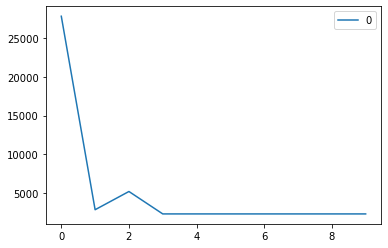

In [164]:
from models import *

hist_len = 168
pred_len = 1
model = DNN1(hist_len, pred_len, 12, 512, 1, device=device).to(device)

loss_list = []
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(0,10):
    train_loss = 0.0
    for idx in range(0, int((len(data) - (hist_len + pred_len-1))*0.6)):
        prev_data = data.iloc[idx:idx+hist_len, [0,1,2,3,4,5,6,7,-4,-3,-2,-1]].astype(float)      #input : 부산, 인천, 주기데이터
        pred_data = data.iloc[idx+hist_len:idx+hist_len+pred_len, [0,4]].astype(float)                #output : 부산 발전율 0

        prev_data = torch.tensor(prev_data.values).to(device)
        pred_data = torch.tensor(pred_data.values).to(device)
        optimizer.zero_grad()
        
        out = model(prev_data)
        loss = F.mse_loss(out.float(), pred_data.float())
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    loss_list.append(train_loss)
pd.DataFrame(loss_list).plot()
    

    
# data.iloc[0:2]

In [ ]:
from main import test

In [169]:
test_loss = 0.0
index_range = [idx for idx in range(int((len(data) - (hist_len + pred_len-1))*0.6), int((len(data) - (hist_len + pred_len-1))))]
result_df = pd.DataFrame(columns=['model_prediction', 'real_value'], index=index_range)
result_idx = 0
for idx in range(int((len(data) - (hist_len + pred_len-1))*0.6), int((len(data) - (hist_len + pred_len-1)))):
    prev_data = data.iloc[idx:idx+hist_len, [0,1,2,3,4,5,6,7,-4,-3,-2,-1]].astype(float)      #부산, 인천
    pred_data = data.iloc[idx+hist_len:idx+hist_len+pred_len, [0,4]].astype(float)
    # print(prev_data.shape)
    # print(pred_data.shape)
    # print(torch.Tensor(prev_data.values))
    prev_data = torch.tensor(prev_data.values).to(device)
    pred_data = torch.tensor(pred_data.values).to(device)
    # optimizer.zero_grad()
    out = model(prev_data)
    loss = F.mse_loss(out.float(), pred_data.float())
    # print(out.shape)
    # print(pred_data.shape)
    # print(np.expand_dims(pred_data[0].cpu(), axis=0))
    result_df.to_numpy()[result_idx, :] = np.vstack((out[:,0].cpu().detach().numpy(),(np.expand_dims(pred_data[:,1].cpu(), axis=0)))).T
    result_idx += 1
    # loss.backward()
    # optimizer.step()
    # print(loss)
    test_loss+=loss.item()
loss_list.append(test_loss)

f:\OneDrive - 고려대학교\내 드라이브\고려대학교\VS_Projects_Graduate\Projects\Local_Solar_Ratio\models.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype = torch.float32)
<ipython-input-169-993b7752e2b6>:15: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out.float(), pred_data.float())


<AxesSubplot:>

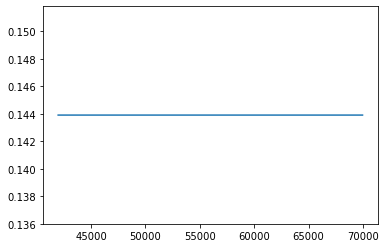

In [178]:
result_df.iloc[:,0].plot()

In [382]:
os.getcwd()

'F:\\OneDrive - 고려대학교\\내 드라이브\\고려대학교\\VS_Projects_Graduate\\Projects\\Local_Solar_Ratio'

In [15]:
from pytorch_forecasting.data.timeseries import TimeSeriesDataSet

In [388]:
data.columns

Index(['Busan_Solar_Ratio', 'Busan_Temp', 'Busan_Precipitation', 'Busan_PM10',
       'Incheon_Solar_Ratio', 'Incheon_Temp', 'Incheon_Precipitation',
       'Incheon_PM10', 'Hadong_Solar_Ratio', 'Hadong_Temp',
       'Hadong_Precipitation', 'Hadong_PM10', 'Year_X', 'Year_Y', 'Time_X',
       'Time_Y'],
      dtype='object')

In [477]:
data

,time_idx,Group,Solar_Ratio,Temp,Precipitation,PM10,Year_X,Year_Y,Time_X,Time_Y
0,0,0,0.0,-2.3,NaN,40,1.0,0.0,0.965926,0.258819
1,1,0,0.0,-2.4,NaN,39,1.0,0.0,0.866025,0.5
2,2,0,0.0,-2.5,NaN,47,1.0,0.0,0.707107,0.707107
3,3,0,0.0,-2.0,NaN,42,1.0,0.0,0.5,0.866025
4,4,0,0.0,-2.3,NaN,42,1.0,0.0,0.258819,0.965926
...,...,...,...,...,...,...,...,...,...,...
70123,70123,2,0.0,-0.4,NaN,17.0,0.999852,-0.017213,0.5,-0.866025
70124,70124,2,0.0,-0.9,NaN,21.0,0.999852,-0.017213,0.707107,-0.707107
70125,70125,2,0.0,-1.1,NaN,19.0,0.999852,-0.017213,0.866025,-0.5
70126,70126,2,0.0,-0.9,NaN,21.0,0.999852,-0.017213,0.965926,-0.258819


In [12]:
data = data.reset_index(drop=True)

In [16]:
dataset = TimeSeriesDataSet(data, time_idx='time_idx', target='Solar_Ratio', group_ids=['Group'], allow_missing_timesteps=True)

In [17]:
dataloader = dataset.to_dataloader(batch_size = 4)

In [18]:
for i in dataloader:
    print(i)
    break

({'encoder_cat': tensor([], size=(4, 30, 0), dtype=torch.int64), 'encoder_cont': tensor([], size=(4, 30, 0)), 'encoder_target': tensor([[    0,     0,     0,   199,   423,  2016,  4216,  6944,  6569,  6249,
          6759,  6277,  3732,   815,    27,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,    58,   758,  1571,  2374],
        [  125,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           120,   246,  1763,  4952, 10252, 10028, 13970, 14524, 14331, 12981,
         10427,  7334,  4501,  1496,   129,     0,     0,     0,     0,     0],
        [11299, 11970,  3957,  1566,  1651,   613,   147,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   760,  3372,  7279,
          4842,  7626, 10711,  6236,  5091,  4505,  4249,  2106,  1624,   741],
        [ 4084,  5495,  7105,  5363,  2944,  3266,  3130,   676,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


In [26]:
arrow.get("2015010101", 'YYYYMMDDHH', tzinfo='Asia/Seoul')

<Arrow [2015-01-01T01:00:00+09:00]>

In [28]:
[r for r in arrow.Arrow.range('hour', arrow.get("2015010101", 'YYYYMMDDHH', tzinfo='Asia/Seoul'), arrow.get("2016010101", 'YYYYMMDDHH', tzinfo='Asia/Seoul'))]

[<Arrow [2015-01-01T01:00:00+09:00]>,
 <Arrow [2015-01-01T02:00:00+09:00]>,
 <Arrow [2015-01-01T03:00:00+09:00]>,
 <Arrow [2015-01-01T04:00:00+09:00]>,
 <Arrow [2015-01-01T05:00:00+09:00]>,
 <Arrow [2015-01-01T06:00:00+09:00]>,
 <Arrow [2015-01-01T07:00:00+09:00]>,
 <Arrow [2015-01-01T08:00:00+09:00]>,
 <Arrow [2015-01-01T09:00:00+09:00]>,
 <Arrow [2015-01-01T10:00:00+09:00]>,
 <Arrow [2015-01-01T11:00:00+09:00]>,
 <Arrow [2015-01-01T12:00:00+09:00]>,
 <Arrow [2015-01-01T13:00:00+09:00]>,
 <Arrow [2015-01-01T14:00:00+09:00]>,
 <Arrow [2015-01-01T15:00:00+09:00]>,
 <Arrow [2015-01-01T16:00:00+09:00]>,
 <Arrow [2015-01-01T17:00:00+09:00]>,
 <Arrow [2015-01-01T18:00:00+09:00]>,
 <Arrow [2015-01-01T19:00:00+09:00]>,
 <Arrow [2015-01-01T20:00:00+09:00]>,
 <Arrow [2015-01-01T21:00:00+09:00]>,
 <Arrow [2015-01-01T22:00:00+09:00]>,
 <Arrow [2015-01-01T23:00:00+09:00]>,
 <Arrow [2015-01-02T00:00:00+09:00]>,
 <Arrow [2015-01-02T01:00:00+09:00]>,
 <Arrow [2015-01-02T02:00:00+09:00]>,
 <Arrow [201

In [337]:
data

torch.Size([64, 60, 8])

In [235]:
KORDataset

NameError: name 'KORDataset' is not defined

In [236]:
np.max(df)

model_prediction    0.825995
real_value          1.000000
dtype: float64

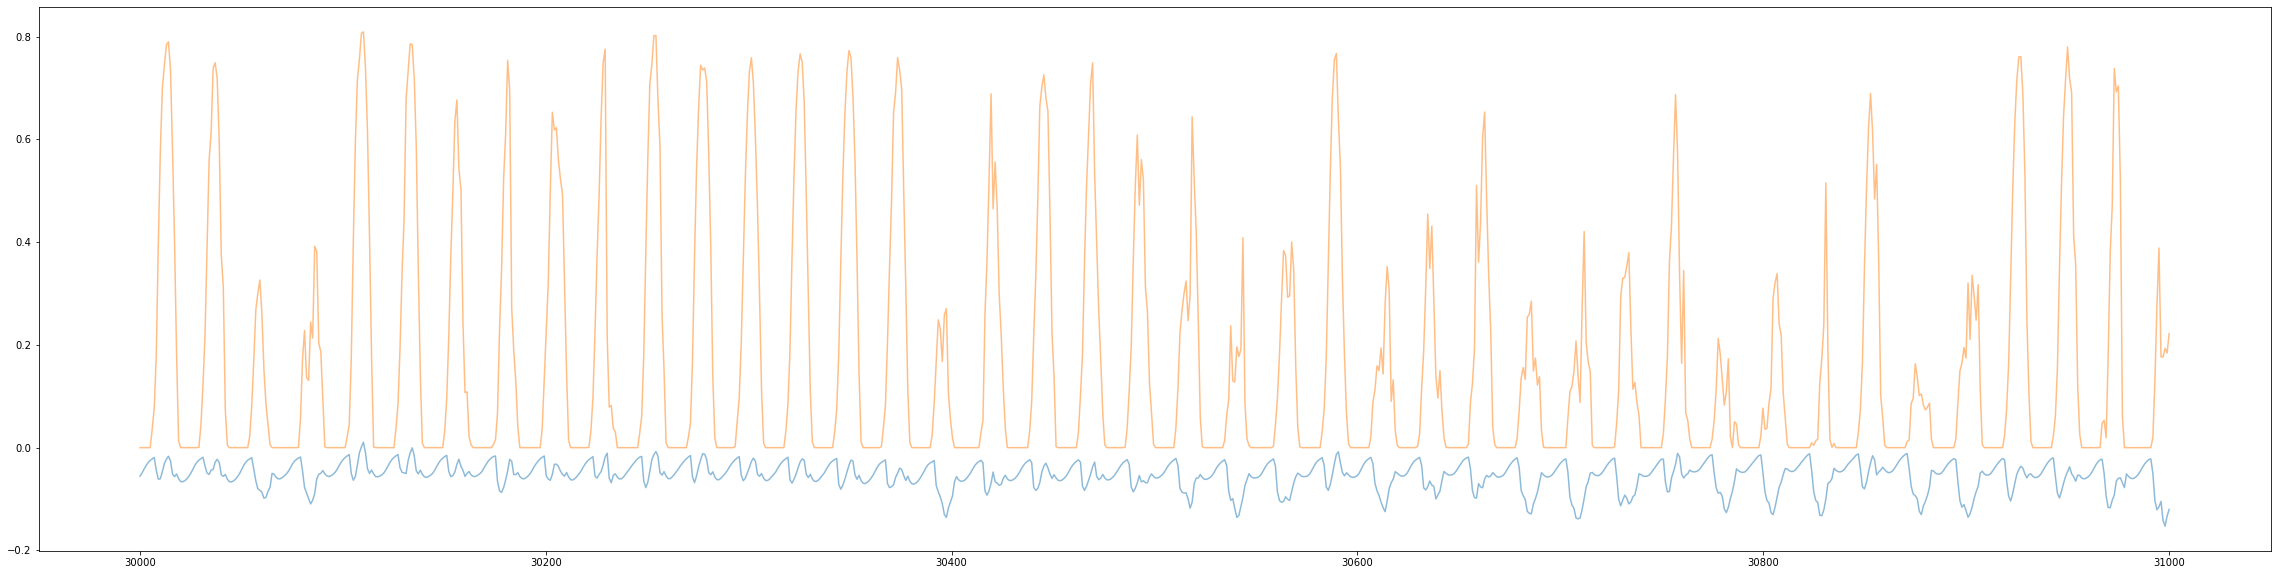

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv(os.path.join(os.getcwd(), 'result', '20220223124857_hist120_pred1_modelDNN2_epoch20_trainBusan','pred_result_train_Busan_testarea_2.csv'), index_col=0)
# df[:8760]
view_start = 30000
view_end = 31000
plt.figure(figsize=(40,10))
plt.plot(np.linspace(view_start,view_end, view_end - view_start), df.iloc[view_start:view_end, :], alpha=0.5)

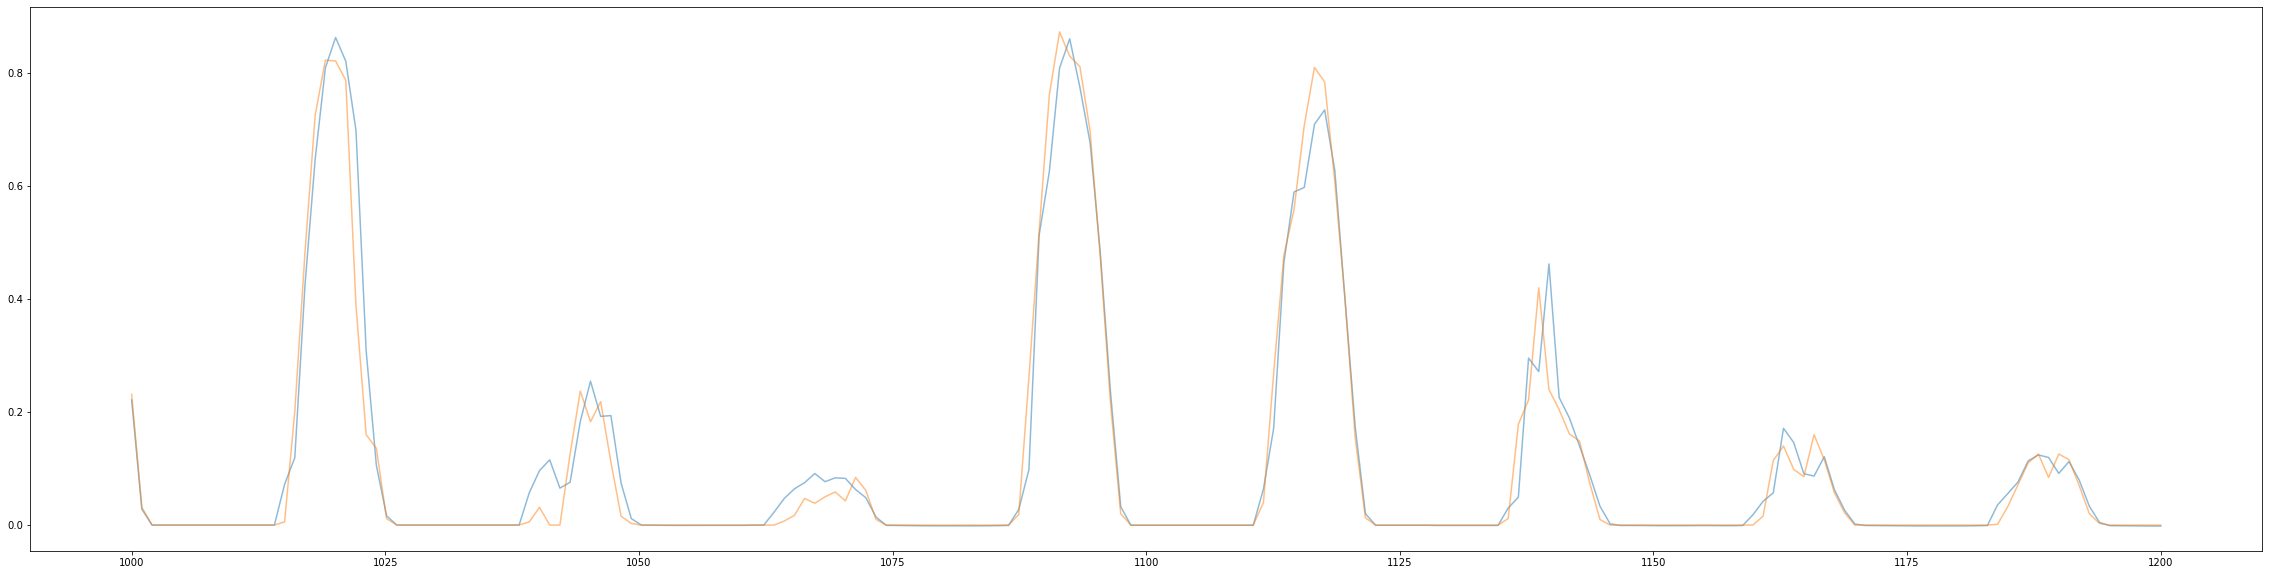

In [281]:
view_start = 1000
view_end = 1200
plt.figure(figsize=(40,10))
plt.plot(np.linspace(view_start,view_end, view_end - view_start), df[view_start:view_end], alpha=0.5)

In [42]:
for i in range(len(location_var)):
    print(location_var[i])
    plt.figure(figsize=(40,10))
    plt.plot(data[:,:,0][i])
    plt.show()

NameError: name 'location_var' is not defined

In [7]:
# loc_list = [location_var.index('부산복합1단계'), location_var.index('인천수산정수장'), location_var.index('하동본부')]
loc_list = [location_var.index('부산복합자재창고'), location_var.index('인천수산정수장'), location_var.index('하동보건소')]
weather_list = [weather_var.index('발전률'), weather_var.index('기온(°C)'),weather_var.index('강수량(mm)'), weather_var.index('PM10'),\
                weather_var.index('측정일시')]

In [93]:
import arrow
temp = data[loc_list][:, :, weather_list]

In [94]:
temp

array([[[0.0, -2.3, nan, 40, 2013010101],
        [0.0, -2.4, nan, 39, 2013010102],
        [0.0, -2.5, nan, 47, 2013010103],
        ...,
        [0.0, -0.2, nan, 12.0, 2020123122],
        [0.0, -0.7, nan, 20.0, 2020123123],
        [0.0, -0.7, nan, 24.0, 2020123124]],

       [[0.0, -6.9, nan, 43, 2013010101],
        [0.0, -6.9, nan, 36, 2013010102],
        [0.0, -6.7, nan, 30, 2013010103],
        ...,
        [0.0, -6.8, nan, 37.0, 2020123122],
        [0.0, -6.3, nan, 33.0, 2020123123],
        [0.0, -6.8, nan, 20.0, 2020123124]],

       [[0.0, -1.2, nan, 39, 2013010101],
        [0.0, -1.5, nan, 16, 2013010102],
        [0.0, -1.9, nan, 17, 2013010103],
        ...,
        [0.0, -1.1, nan, 19.0, 2020123122],
        [0.0, -0.9, nan, 21.0, 2020123123],
        [0.0, -0.4, nan, 22.0, 2020123124]]], dtype=object)

In [8]:
def get_idx(t):
    t0=arrow.get("2013010101", 'YYYYMMDDHH', tzinfo='Asia/Seoul')   #varies by file
    t=arrow.get(str(t), 'YYYYMMDDHH', tzinfo='Asia/Seoul')
    return int((t.timestamp() - t0.timestamp()) / (60 * 60))    #Return Hourly Data Index

def convert_2d(t):
    
    idx = get_idx(t)
    year = arrow.get(str(t), 'YYYYMMDDHH', tzinfo='Asia/Seoul').date().year
    month = arrow.get(str(t), 'YYYYMMDDHH', tzinfo='Asia/Seoul').date().month
    day = arrow.get(str(t), 'YYYYMMDDHH', tzinfo='Asia/Seoul').date().day
    
    if year >= 2016:
        if month >= 3:
            idx -= 24
            
    if year >= 2020:
        if month >= 3:
            idx -= 24    
            
    date = idx // 24 % 365
    hour = idx % 24 + 1
    
    date_cos = np.cos(date * 2 * np.pi / 365)
    date_sin = np.sin(date * 2 * np.pi / 365)
    
    hour_cos = np.cos(hour * 2 * np.pi / 24)
    hour_sin = np.sin(hour * 2 * np.pi / 24)
    
    return date_cos, date_sin, hour_cos, hour_sin

In [96]:
t_data = np.empty(shape=(70128,4))
for i in range(len(temp[0, :, 4])):
    t_data[i] = convert_2d(temp[0, :, 4][i])
    
t_pile = np.expand_dims(t_data, axis=0).copy()
t_pile = np.vstack((t_pile, np.expand_dims(t_data, axis=0)))
t_pile = np.vstack((t_pile, np.expand_dims(t_data, axis=0)))

converted_data = np.concatenate((temp[:,:,:4], t_pile), axis=2)    

In [97]:
converted_data

array([[[0.0, -2.3, nan, ..., 0.0, 0.9659258262890683,
         0.25881904510252074],
        [0.0, -2.4, nan, ..., 0.0, 0.8660254037844387,
         0.49999999999999994],
        [0.0, -2.5, nan, ..., 0.0, 0.7071067811865476,
         0.7071067811865476],
        ...,
        [0.0, -0.2, nan, ..., -0.01721335615583528, 0.8660254037844384,
         -0.5000000000000004],
        [0.0, -0.7, nan, ..., -0.01721335615583528, 0.9659258262890681,
         -0.25881904510252157],
        [0.0, -0.7, nan, ..., 0.017213356155834685, 1.0,
         -2.4492935982947064e-16]],

       [[0.0, -6.9, nan, ..., 0.0, 0.9659258262890683,
         0.25881904510252074],
        [0.0, -6.9, nan, ..., 0.0, 0.8660254037844387,
         0.49999999999999994],
        [0.0, -6.7, nan, ..., 0.0, 0.7071067811865476,
         0.7071067811865476],
        ...,
        [0.0, -6.8, nan, ..., -0.01721335615583528, 0.8660254037844384,
         -0.5000000000000004],
        [0.0, -6.3, nan, ..., -0.01721335615583528, 0.96

In [9]:
np.save('busan_incheon_hadong_solarratio_temp_pre_pm_time2d_2013_2020.npy', converted_data)

NameError: name 'converted_data' is not defined

In [ ]:
total_data = data

array([[nan, nan, nan, ..., 0.0, 0.0, 0.0],
       [nan, nan, nan, ..., 0.0, 0.0, 0.0],
       [nan, nan, nan, ..., 0.0, 0.0, 0.0],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., 0.0, 0.0, 0.0],
       [nan, nan, nan, ..., 0.0, 0.0, 0.0]], dtype=object)

In [91]:
for idx, arr in enumerate(data[:,:,0]):
    print(location_var[idx], end=' ')
    print(np.mean(arr[~np.isnan(arr.astype(float))]))
    # print(get_nonan_mean)

경상대 0.15021112964076413
광양항세방 0.1376159743069732
구미 0.11374984972754973
남동발전_본사사옥 0.13007599091476807
영동 0.1443401801005852
예천 0.1403983202144658
남제주소내 0.11988131156381131
부산복합자재창고 0.14701147847599066
부산복합1단계 0.07135159525146495
부산수처리장 0.1444063260340626
부산신항 0.11401405603666366
부산본부 0.16170858315953965
삼척소내 0.15630893667389967
신인천소내 0.1430224803929952
신인천전망대 0.1361628654872734
신인천해수취수구 0.14566428534949155
영월본부 0.07851857618249948
영월철도부지 0.15111926758775
위미2리 0.14317448561214027
인천수산정수장 0.15172956196445053
하동공설운동장 0.13380274016316104
하동변전소 0.1592495757757246
하동보건소 0.14902505989048576
하동본부 0.11710071733491849
하동정수장 0.11869930805482297
하동하수처리장 0.15607423360919512
광양항 0.11427985941008338
당진 0.14434687989045522
당진매립장_송악 0.11665524814707341
당진자재창고 0.13830332690588013
동해 0.1146066118935847
수원환경사업소 0.1611832290036518
황금물류센터 0.1519680964575381
세종시폐기물매립장 0.15687637612192037
연성정수장 0.14889653287644591
영암에프원b 0.15921613744619986
대구 0.10694532594942636
신안 0.13409308869594938


In [126]:
from dataset import KORDataset
data_5 = KORDataset(seq_len=5, locals=[0])
data_60 = KORDataset(seq_len=60, locals=[0])

In [15]:
print(len(data_5), len(data_60))
for

70124 70069


In [159]:
from dataset import KORDataset
from torch.utils.data import DataLoader
import arrow
busan_dataset = KORDataset(seq_len= 60, year=[2014010101, 2021010101], locals=[0])
train_loader = DataLoader(busan_dataset, batch_size=64, drop_last=True)

In [160]:
index_range = [r for r in arrow.Arrow.range('hour', arrow.get(str(2014010101), 'YYYYMMDDHH', tzinfo='Asia/Seoul'), arrow.get(str(2021010101), 'YYYYMMDDHH', tzinfo='Asia/Seoul'))]
print(len(index_range))
result_df = pd.DataFrame(columns=['model_prediction', 'real_value'], index=index_range)
result_idx = 0
for idx, data in enumerate(train_loader):
    x, y = data[:, :48, :], data[:,48:,0]
    # result_df.to_numpy()[result_idx:result_idx+args.batch_size, :] = np.vstack((out[:,0].cpu().detach().numpy(),y[:,0].cpu().detach().numpy())).T
    # print(np.vstack((np.zeros(y[:,0].shape),y[:,0])).T.shape)
    
    result_df.to_numpy()[result_idx:result_idx+64, :] = np.vstack((np.zeros(y[:,0].shape),y[:,0])).T
    result_idx+=64

61369


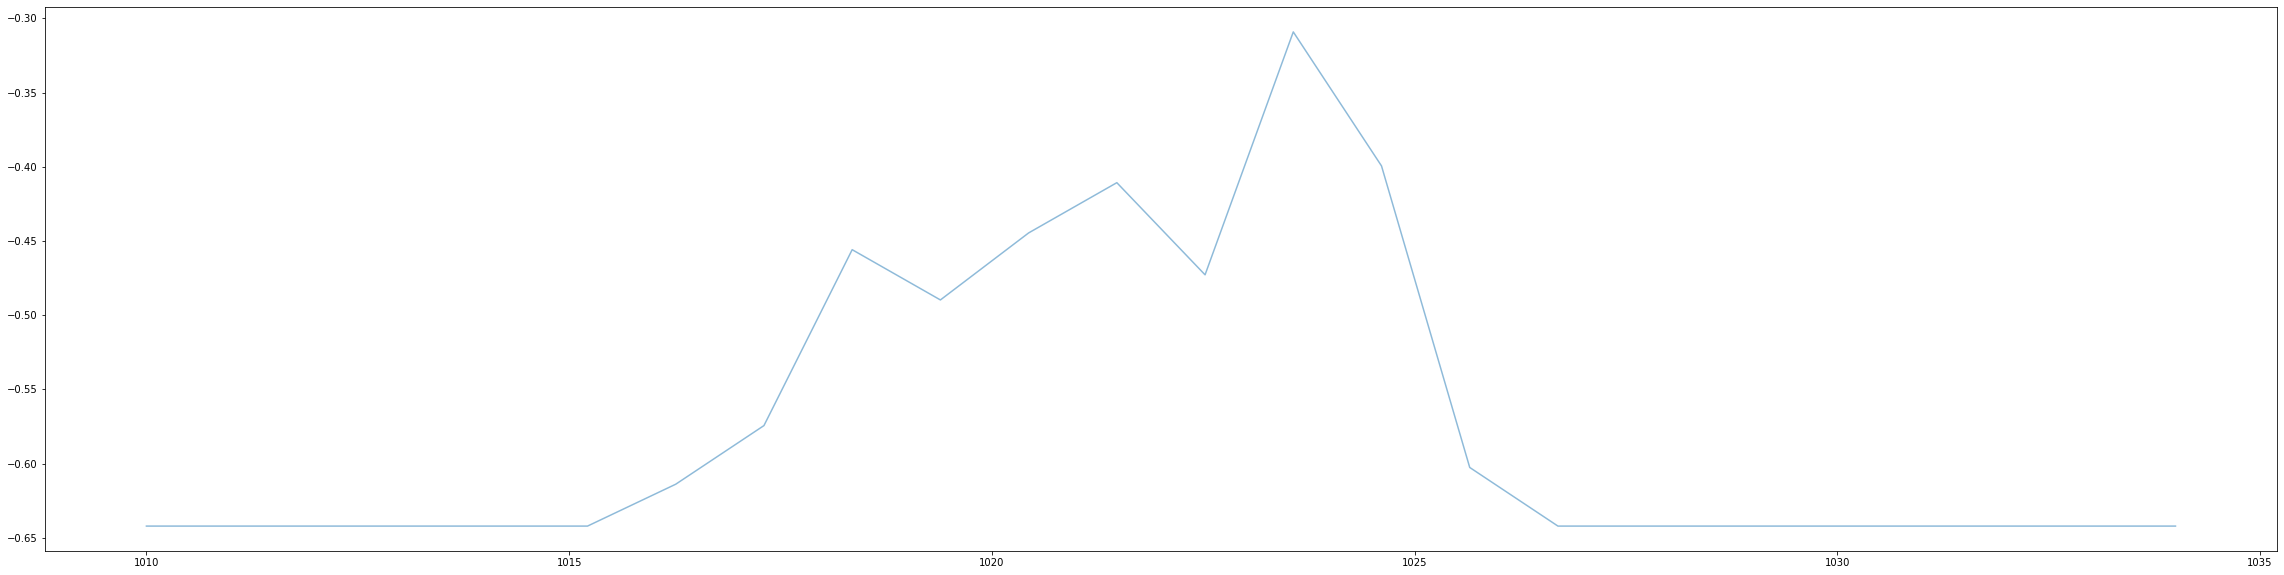

In [161]:
# plt.plot(np.linspace(1,61369, 61369),result_df.iloc[0,200])
view_start = 1010
view_end = 1034
plt.figure(figsize=(40,10))
plt.plot(np.linspace(view_start,view_end, view_end - view_start), result_df.iloc[view_start:view_end, 1], alpha=0.5)

In [52]:
test_data = np.load('busan_incheon_hadong_solarratio_temp_pre_pm_time2d_2013_2020.npy', allow_pickle=True)

In [53]:
test_data[:,:,3]

array([[40, 39, 47, ..., 12.0, 20.0, 24.0],
       [43, 36, 30, ..., 37.0, 33.0, 20.0],
       [39, 16, 17, ..., 19.0, 21.0, 22.0]], dtype=object)

In [77]:
used_data = test_data[:,:,2]

In [78]:
used_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=object)

In [79]:
len(used_data.shape)

2

In [80]:
used_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=object)

7
19
22


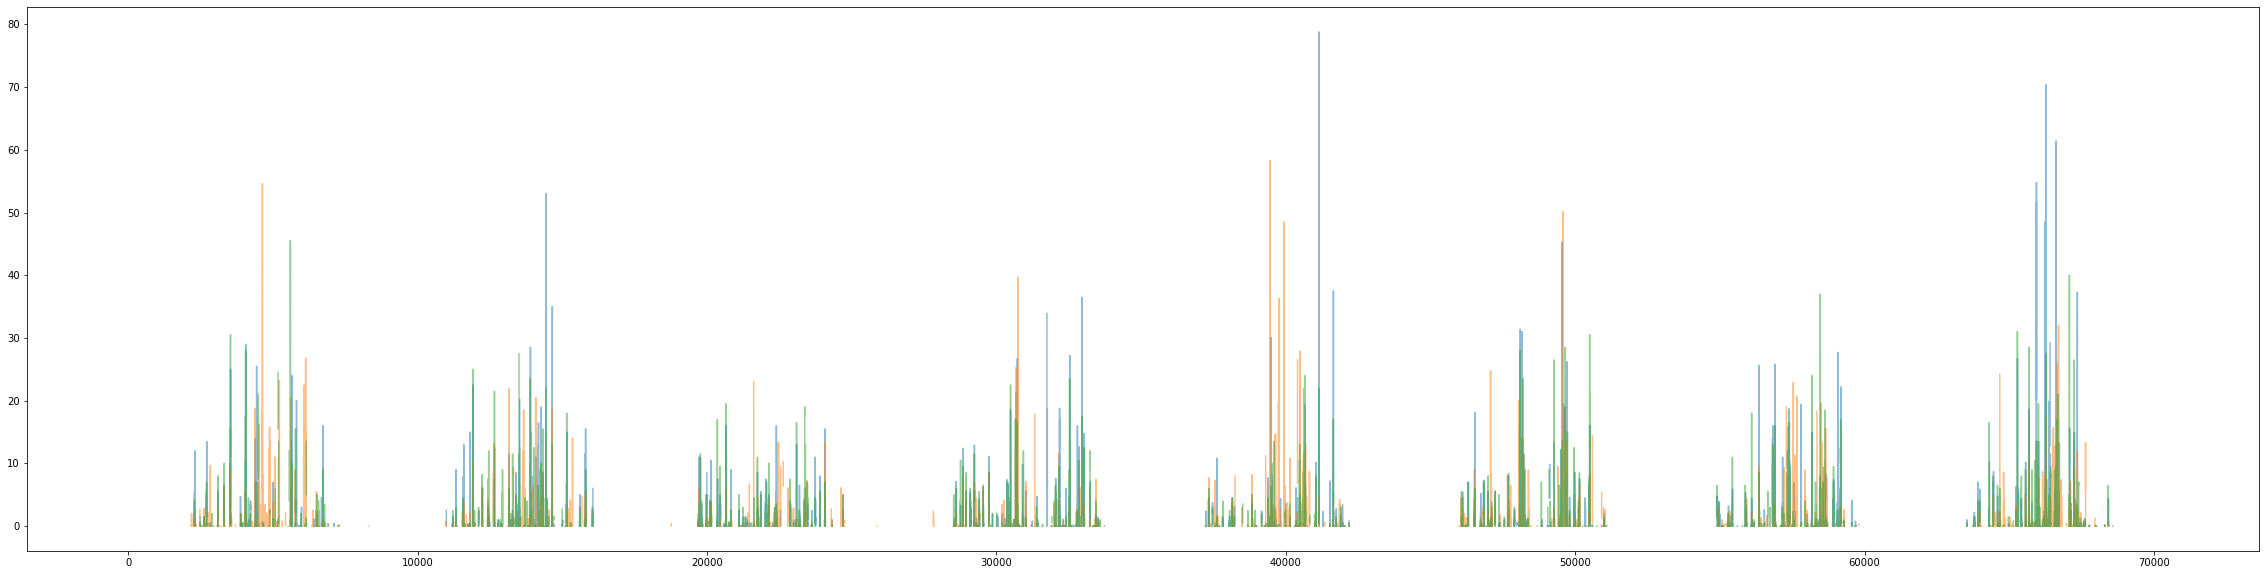

In [81]:
plt.figure(figsize=(40,10))
for i in range(len(used_data)):
    print(loc_list[i])
    plt.plot(used_data[i,:], alpha=0.5)
plt.savefig('solar_ratio.png')
    # plt.show()

In [14]:
pos = np.isnan(data[0][:,1].astype(float))  #temperature
pos = np.isnan(data[0][:,3].astype(float))  #pm10

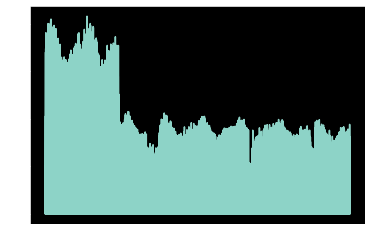

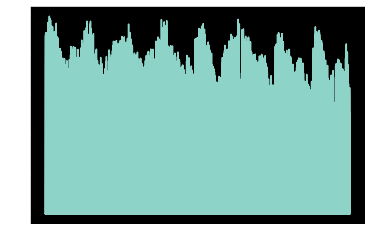

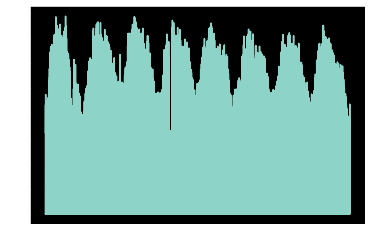

In [21]:
for i in range(3):
    plt.figure()
    plt.plot(data[:,:,0][i])

In [1]:
len(data[0][pos])

NameError: name 'data' is not defined

In [81]:
pos.shape

(70128,)

In [77]:
data[0][np.isnan(bfill(ffill(data[0][:,3].reshape(-1,1).astype(float))))]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 8 but corresponding boolean dimension is 1

In [75]:
from utils import *
data[0][:,np.any(np.isnan(bfill(ffill(data[0][:,3].reshape(-1,1).astype(float)))))].shape

(70128, 1, 8)

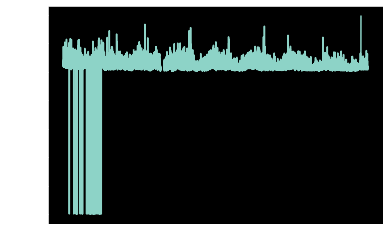

In [49]:
plt.plot(data[0][:,3])

In [16]:
busan_dataset[0], busan_dataset[1]

(array([[-0.54923471, -2.08903449,         nan, -0.17269686,  1.41770434,
         -0.00249542,  1.3660254 ,  0.36602541],
        [-0.54923471, -2.1008557 ,         nan, -0.19133931,  1.41770434,
         -0.00249542,  1.22474486,  0.70710679],
        [-0.54923471, -2.11267688,         nan, -0.04219969,  1.41770434,
         -0.00249542,  0.99999999,  0.99999999]]),
 array([[-0.54923471, -2.1008557 ,         nan, -0.19133931,  1.41770434,
         -0.00249542,  1.22474486,  0.70710679],
        [-0.54923471, -2.11267688,         nan, -0.04219969,  1.41770434,
         -0.00249542,  0.99999999,  0.99999999],
        [-0.54923471, -2.05357092,         nan, -0.13541195,  1.41770434,
         -0.00249542,  0.70710679,  1.22474486]]))

In [6]:
for i in busan_dataset:
    print(i.shape)
    break

NameError: name 'busan_dataset' is not defined

In [70]:
from torch.utils.data import DataLoader

# for idx, temp_data in enumerate(DataLoader(torch.FloatTensor(temp_prec_data[0].astype(float)), batch_size=4)):
#     print(idx, temp_data)
train_loader = DataLoader(busan_dataset, batch_size=32, drop_last=True)
for batch_idx, data in enumerate(train_loader):
    print(batch_idx, data.shape)

0 torch.Size([32, 24, 4])
1 torch.Size([32, 24, 4])
2 torch.Size([32, 24, 4])
3 torch.Size([32, 24, 4])
4 torch.Size([32, 24, 4])
5 torch.Size([32, 24, 4])
6 torch.Size([32, 24, 4])
7 torch.Size([32, 24, 4])
8 torch.Size([32, 24, 4])
9 torch.Size([32, 24, 4])
10 torch.Size([32, 24, 4])
11 torch.Size([32, 24, 4])
12 torch.Size([32, 24, 4])
13 torch.Size([32, 24, 4])
14 torch.Size([32, 24, 4])
15 torch.Size([32, 24, 4])
16 torch.Size([32, 24, 4])
17 torch.Size([32, 24, 4])
18 torch.Size([32, 24, 4])
19 torch.Size([32, 24, 4])
20 torch.Size([32, 24, 4])
21 torch.Size([32, 24, 4])
22 torch.Size([32, 24, 4])
23 torch.Size([32, 24, 4])
24 torch.Size([32, 24, 4])
25 torch.Size([32, 24, 4])
26 torch.Size([32, 24, 4])
27 torch.Size([32, 24, 4])
28 torch.Size([32, 24, 4])
29 torch.Size([32, 24, 4])
30 torch.Size([32, 24, 4])
31 torch.Size([32, 24, 4])
32 torch.Size([32, 24, 4])
33 torch.Size([32, 24, 4])
34 torch.Size([32, 24, 4])
35 torch.Size([32, 24, 4])
36 torch.Size([32, 24, 4])
37 torch.Si

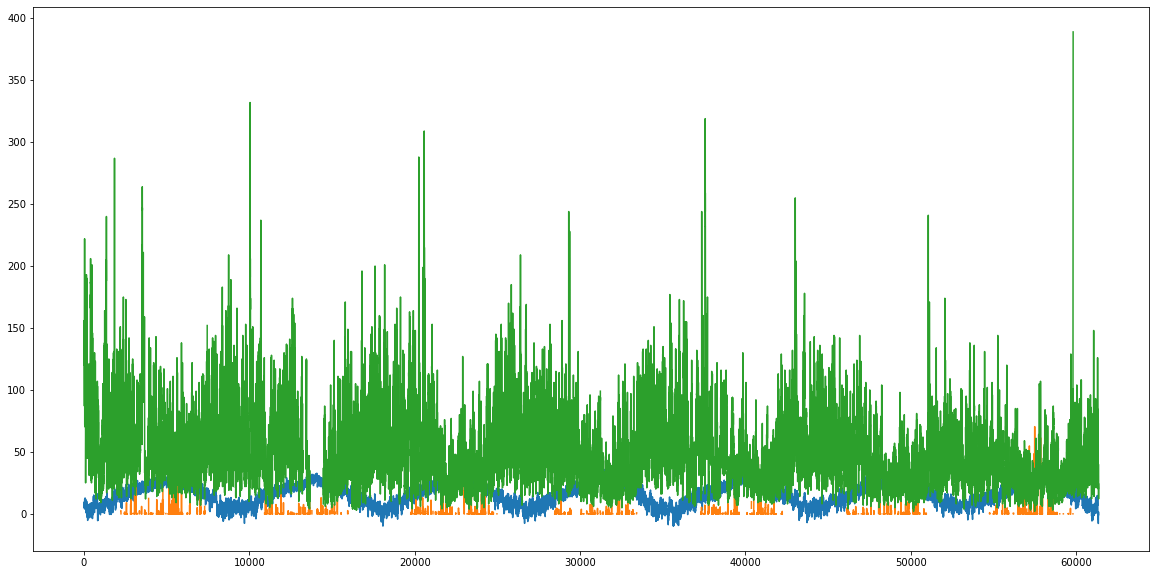

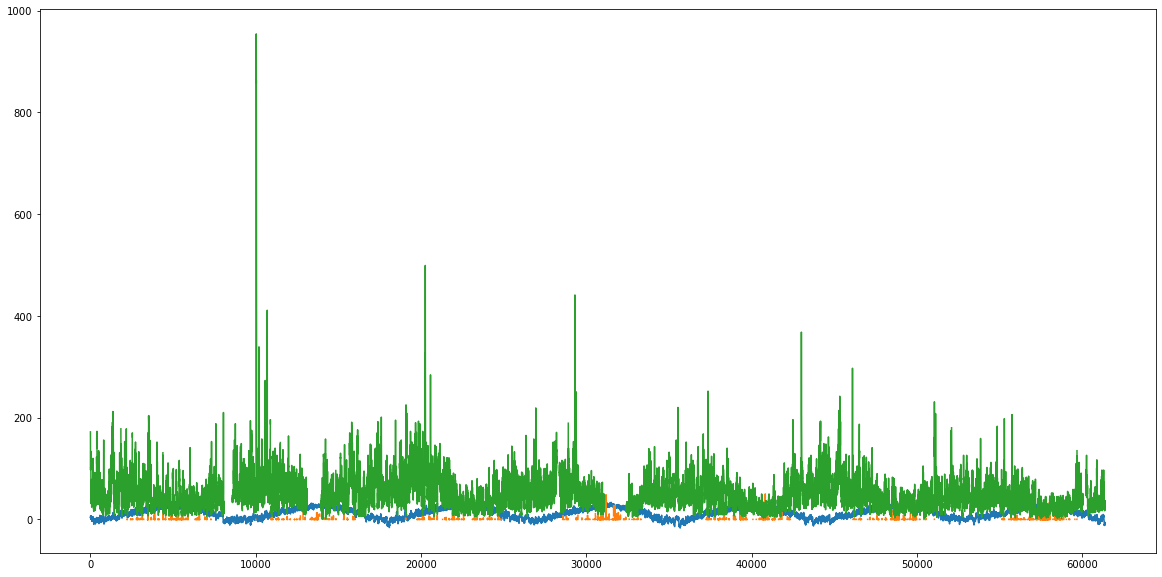

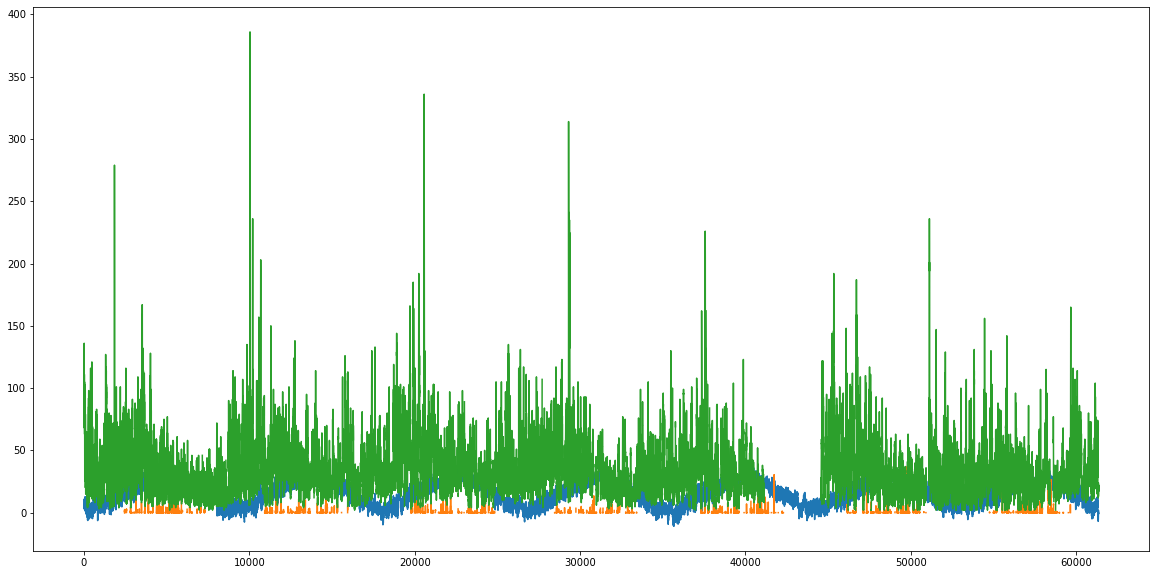

In [177]:
for i in range(3):
    plt.figure(figsize=(20,10))
    plt.plot(temp_prec_data[i])  #부산, 인천, 하동


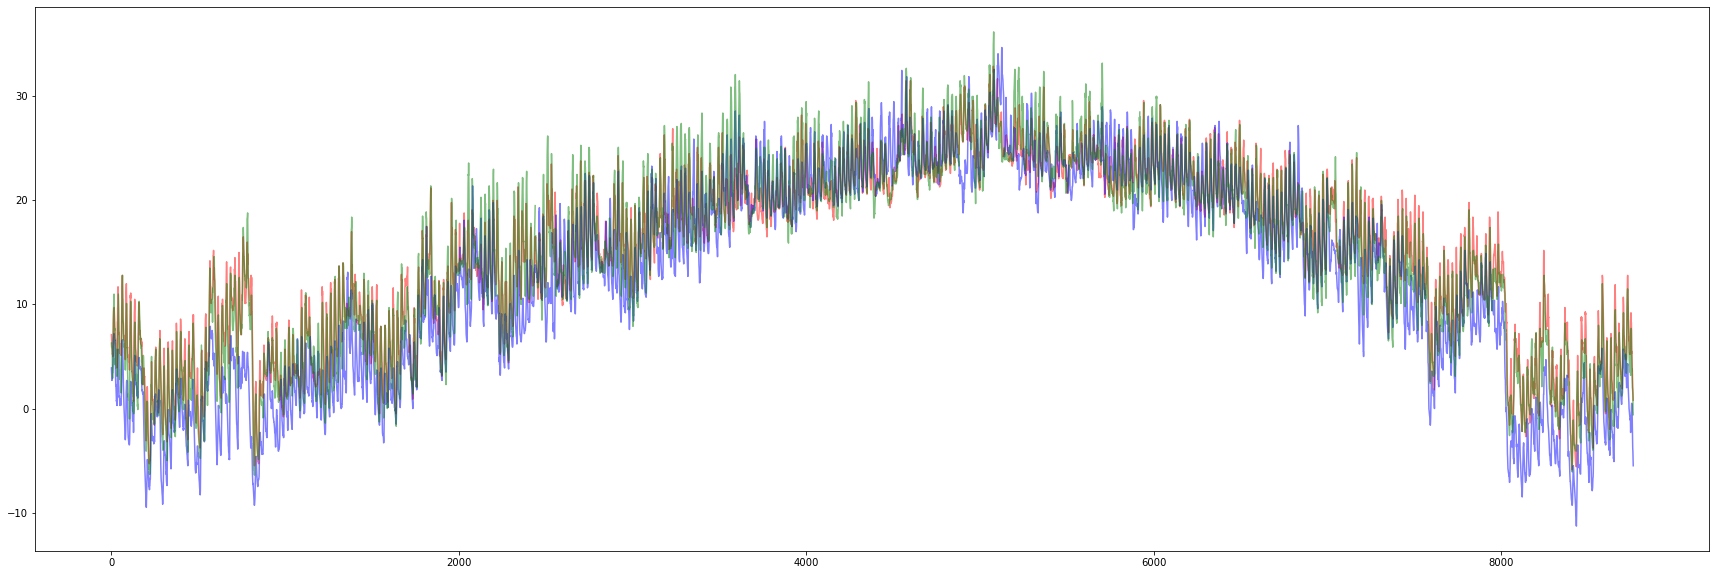

In [194]:
plt.figure(figsize=(30,10))
plt.plot(busan_weather[:8760,0],c='r', alpha=0.5)
plt.plot(incheon_weather[:8760,0], c='b', alpha=0.5)
plt.plot(hadong_weather[:8760,0], c='g', alpha=0.5)

In [195]:
import dtw

In [264]:
def get_nonan_mean(arr):
    return np.mean(arr[~np.isnan(arr.astype(float))]).round(1)
# np.mean(busan_weather[:8760,2][~np.isnan(busan_weather[:8760,2].astype(float))]).round(1)

In [286]:
# ffill along axis 1, as provided in the answer by Divakar
def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

# Simple solution for bfill provided by financial_physician in comment below
def bfill(arr): 
    return ffill(arr[:, ::-1])[:, ::-1]

In [315]:
def get_dtw_distance(array1, array2, seq_start, seq_end, idx):
    '''
    1차원 벡터 두 개, 기간, feature index 받아서
    ffill, bfill로 nan값 처리 후 dtw 값 반환
    '''
    arr1 = array1[seq_start:seq_end, idx].astype(float)
    arr2 = array2[seq_start:seq_end, idx].astype(float)
    if idx==1:
        arr1 = np.nan_to_num(arr1, nan=0.0)
        arr2 = np.nan_to_num(arr2, nan=0.0)
    else:
        arr1 = bfill(ffill(np.expand_dims(arr1, axis=0)))
        arr2 = bfill(ffill(np.expand_dims(arr2, axis=0)))
        
    return dtw.dtw(arr1, arr2, keep_internals=True)
    

In [373]:
temp0 = get_dtw_distance(busan_weather, incheon_weather, 0, 8760, 0)    #다름
temp1 = get_dtw_distance(busan_weather, hadong_weather, 0, 8760, 0)     #비슷
temp2 = get_dtw_distance(incheon_weather, hadong_weather, 0, 8760, 0)   #다름


In [398]:
dtw_result = np.zeros(shape=(3,3,3))

In [395]:
weather_data = [busan_weather, incheon_weather, hadong_weather]

In [431]:
dtw_result = np.zeros(shape=(3,3,3))
weather_data = [busan_weather, incheon_weather, hadong_weather]
for i in range(3):
    for j in range(3):
        for k in range(3):
            if j > i:
                dtw_result[i,j,k] = get_dtw_distance(weather_data[i], weather_data[j], 8760, 2*8760, k).normalizedDistance


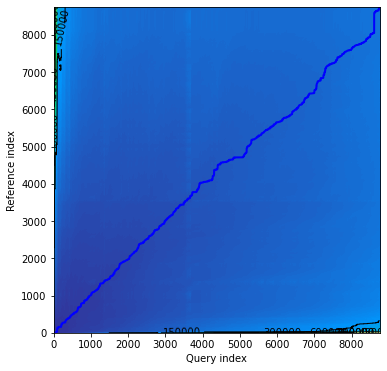

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [358]:
dtw.dtwPlot(temp0, 'density')

In [377]:
temp2.normalizedDistance

0.7544406392694147

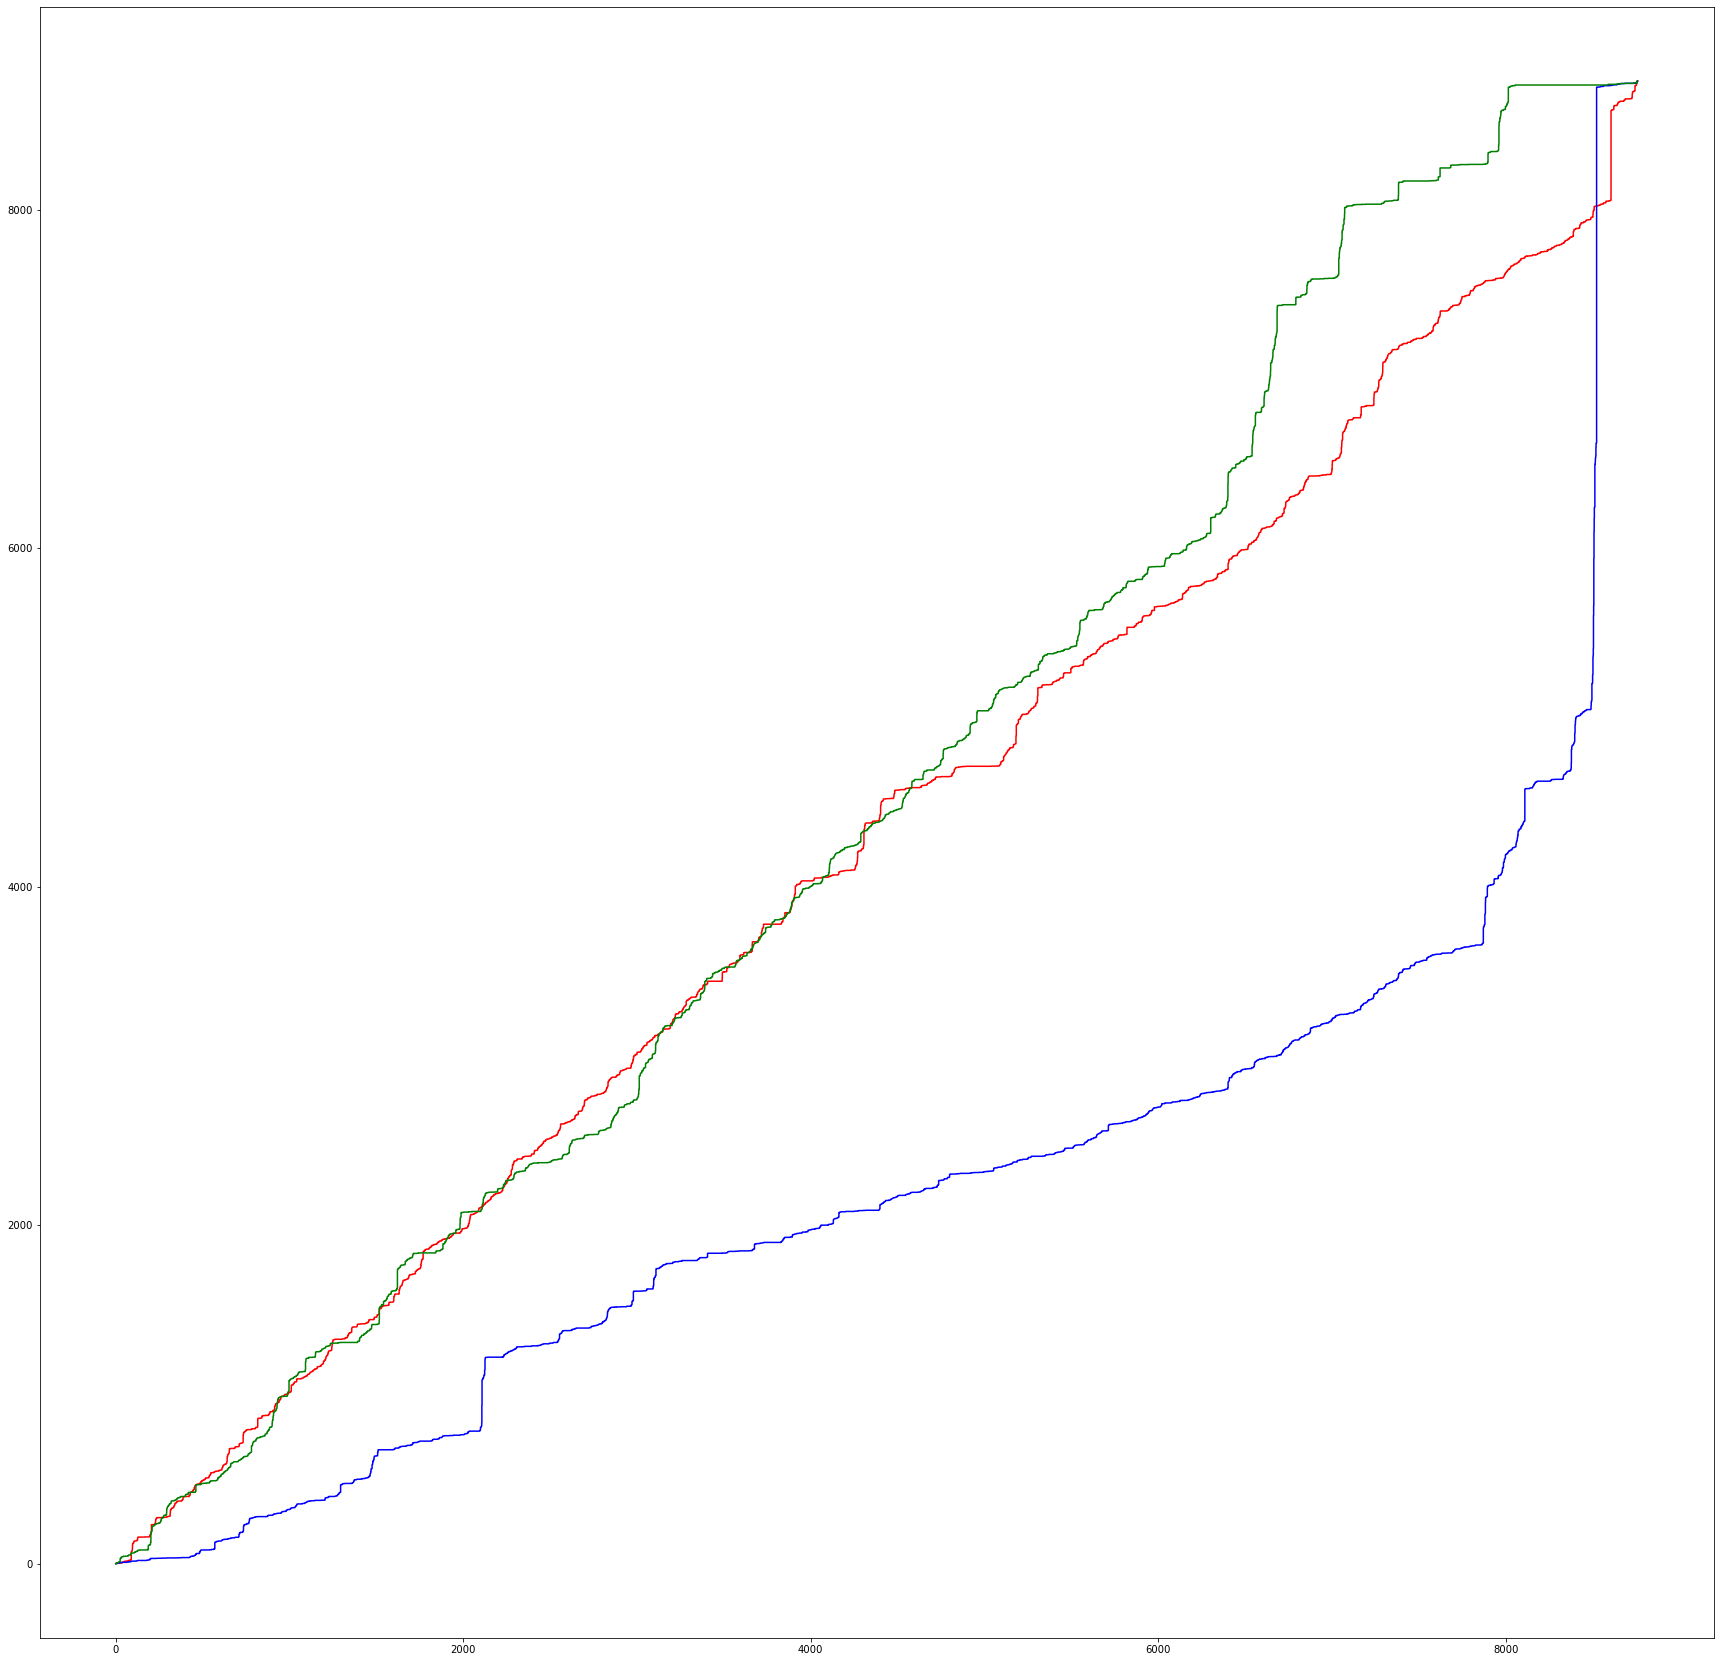

In [354]:
plt.figure(figsize=(30,30))
plt.plot(temp0.index1, temp0.index2, 'r')
plt.plot(temp1.index1, temp1.index2, 'b')
plt.plot(temp2.index1, temp2.index2, 'g')

13049.900000000347

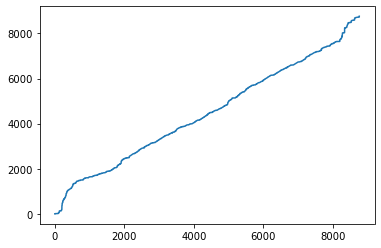

In [263]:
plt.plot(temp.index1, temp.index2)
temp.distance

<Figure size 2160x720 with 0 Axes>

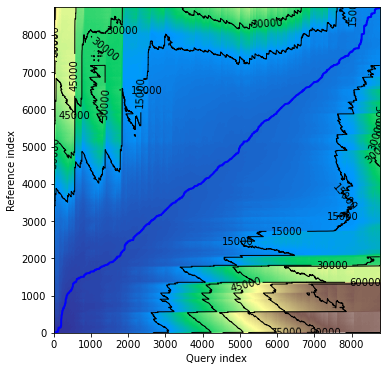

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [246]:
plt.figure(figsize=(30,10))
dtw.dtw(busan_weather[:8760,0].astype(float), incheon_weather[:8760,0].astype(float), keep_internals=True).plot(type='density')

In [553]:
for idx, data in enumerate(DataLoader(torch.FloatTensor(dataset[0]), batch_size=4)):
        print(idx, data)

0 tensor([[-2.3000,     nan, 40.0000],
        [-2.4000,     nan, 39.0000],
        [-2.5000,     nan, 47.0000],
        [-2.0000,     nan, 42.0000]])
1 tensor([[-2.3000,     nan, 42.0000],
        [-2.5000,     nan, 53.0000],
        [-2.7000,     nan, 45.0000],
        [-2.6000,     nan, 55.0000]])
2 tensor([[-2.4000,     nan, 65.0000],
        [ 1.1000,     nan, 77.0000],
        [ 2.4000,     nan, 75.0000],
        [ 5.4000,     nan, 88.0000]])
3 tensor([[ 6.7000,     nan, 58.0000],
        [ 6.2000,     nan, 55.0000],
        [ 7.7000,     nan, 69.0000],
        [ 7.5000,     nan, 73.0000]])
4 tensor([[  6.3000,      nan,  73.0000],
        [  5.1000,      nan, 126.0000],
        [  4.3000,      nan, 176.0000],
        [  3.6000,      nan, 141.0000]])
5 tensor([[  3.7000,      nan, 148.0000],
        [  3.5000,      nan, 153.0000],
        [  2.8000,      nan, 151.0000],
        [  2.4000,      nan, 150.0000]])
6 tensor([[  2.3000,      nan, 149.0000],
        [  2.1000,      nan,

KeyboardInterrupt: 

In [18]:
pd.DataFrame(np.load('busan_incheon_hadong_solarratio_temp_pre_pm_time2d_2013_2020.npy', allow_pickle=True)[0])

,0,1,2,3,4,5,6,7
0,0.0,-2.3,NaN,40,1.0,0.0,0.965926,0.258819
1,0.0,-2.4,NaN,39,1.0,0.0,0.866025,0.5
2,0.0,-2.5,NaN,47,1.0,0.0,0.707107,0.707107
3,0.0,-2.0,NaN,42,1.0,0.0,0.5,0.866025
4,0.0,-2.3,NaN,42,1.0,0.0,0.258819,0.965926
...,...,...,...,...,...,...,...,...
70123,0.0,0.6,NaN,21.0,0.999852,-0.017213,0.5,-0.866025
70124,0.0,0.1,NaN,20.0,0.999852,-0.017213,0.707107,-0.707107
70125,0.0,-0.2,NaN,12.0,0.999852,-0.017213,0.866025,-0.5
70126,0.0,-0.7,NaN,20.0,0.999852,-0.017213,0.965926,-0.258819


In [19]:
from dataset import KORDataset
busan_dataset = KORDataset(seq_len=3, locals=[0])
dataloader = DataLoader(busan_dataset, batch_size=64, shuffle=False)
# train_loader = DataLoader(busan_dataset, batch_size=args.batch_size, drop_last=True)

In [1]:
import pandas as pd
import numpy as np

In [181]:
train_dataset = pd.read_csv(f'./dataset/solar_weather_2017_2020_경상대.csv', encoding='cp949', index_col=0)
solar_dataset = pd.read_csv(f'./dataset/features/total_area_2017_2020_발전률.csv', encoding='cp949', index_col=0)
ray_dataset = pd.read_csv(f'./dataset/features/others/total_area_2017_2020_일사(MJ__m2).csv', encoding='utf8', index_col=0)



In [182]:
solar_dataset.columns

Index(['경상대', '광양항세방', '구미', '남동발전_본사사옥', '영동', '예천', '남제주소내', '부산복합자재창고',
       '부산복합1단계', '부산수처리장', '부산신항', '부산본부', '삼척소내', '신인천소내', '신인천전망대',
       '신인천해수취수구', '영월본부', '영월철도부지', '위미2리', '인천수산정수장', '하동공설운동장', '하동변전소',
       '하동보건소', '하동본부', '하동정수장', '하동하수처리장', '광양항', '당진', '당진매립장_송악', '당진자재창고',
       '동해', '수원환경사업소', '황금물류센터', '세종시폐기물매립장', '연성정수장', '영암에프원b', '대구', '신안'],
      dtype='object')

In [183]:
ray_dataset = ray_dataset.fillna(0)

In [184]:
ray_dataset = ray_dataset + 0.001

In [185]:
ray_dataset.columns = solar_dataset.columns
ray_dataset

,경상대,광양항세방,구미,남동발전_본사사옥,영동,예천,남제주소내,부산복합자재창고,부산복합1단계,부산수처리장,...,당진매립장_송악,당진자재창고,동해,수원환경사업소,황금물류센터,세종시폐기물매립장,연성정수장,영암에프원b,대구,신안
0,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
2,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
3,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
4,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
35060,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
35061,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
35062,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [186]:

temp = solar_dataset / ray_dataset

In [135]:
temp.loc[12::24]

,경상대,광양항세방,구미,남동발전_본사사옥,영동,예천,남제주소내,부산복합자재창고,부산복합1단계,부산수처리장,...,당진매립장_송악,당진자재창고,동해,수원환경사업소,황금물류센터,세종시폐기물매립장,연성정수장,영암에프원b,대구,신안
12,0.495499,NaN,0.000000,0.453418,0.555543,588.95,554.913265,0.318198,0.183545,NaN,...,0.365064,0.372429,390.0,0.382085,0.359901,0.356235,0.436581,0.487662,0.232951,0.370355
36,0.512490,NaN,0.000000,0.477261,1.438975,193.50,161.234694,0.327960,0.185499,NaN,...,0.216176,0.568492,357.0,0.927949,0.370618,0.329631,0.385558,0.447199,0.234453,0.353705
60,0.502999,NaN,0.000000,0.467616,0.507999,643.15,588.367347,0.341312,0.195697,NaN,...,0.266763,0.472845,386.0,0.487640,0.375303,0.377205,0.452137,0.477363,0.272020,0.396119
84,0.515732,NaN,0.000000,0.491893,0.499151,622.10,489.484694,0.389593,0.177558,NaN,...,0.339439,0.569410,380.0,0.479631,0.349011,0.568042,0.458784,0.584981,0.261421,0.252658
108,0.402825,NaN,0.000000,0.285472,0.066742,227.45,228.755102,0.174890,0.111208,NaN,...,0.332745,0.359123,34.0,0.392555,0.385430,0.220627,0.348857,0.289829,0.141824,0.179533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34956,0.165892,0.197020,140.733871,NaN,0.028600,344.45,14.760204,0.318691,0.115727,0.323887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199581,0.121539
34980,0.462045,0.256129,619.475806,NaN,0.029121,539.10,510.025510,0.295564,0.168113,0.352208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.144300,0.354050
35004,0.333326,0.214282,540.000000,NaN,0.095354,410.50,143.525510,0.349065,0.200613,0.405267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090856,0.066654
35028,0.352037,0.263115,768.919355,NaN,0.020666,654.40,220.020408,0.312067,0.181200,0.384431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092717,0.500755


In [187]:
from utils import config

In [188]:
loc_list = config['experiments']['location_used']

In [189]:
temp

,경상대,광양항세방,구미,남동발전_본사사옥,영동,예천,남제주소내,부산복합자재창고,부산복합1단계,부산수처리장,...,당진매립장_송악,당진자재창고,동해,수원환경사업소,황금물류센터,세종시폐기물매립장,연성정수장,영암에프원b,대구,신안
0,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.0,0.0,0.0,NaN,321.140713,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
35060,0.0,0.0,0.0,NaN,623.639775,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
35061,0.0,0.0,0.0,NaN,649.846154,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
35062,0.0,0.0,0.0,NaN,130.401501,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [190]:
temp0 = temp.loc[12::24][['경상대',  '부산복합자재창고',  '인천수산정수장', '하동보건소', '신안']]

In [191]:
temp1 = temp0.copy()

In [192]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit_transform(temp0).shape

(1461, 5)

In [166]:
temp1[:] = scaler.fit_transform(temp0)

In [194]:
temp1.mean()

경상대          2.121863
부산복합자재창고    25.203399
인천수산정수장      0.321436
하동보건소        2.078256
신안           2.065708
dtype: float64

In [202]:
temp1.iloc[:, 0]

12       0.495499
36       0.512490
60       0.502999
84       0.515732
108      0.402825
           ...   
34956    0.165892
34980    0.462045
35004    0.333326
35028    0.352037
35052    0.335024
Name: 경상대, Length: 1461, dtype: float64

In [208]:
for idx in range(temp1.shape[1]):
    temp1.iloc[:,idx][temp1.iloc[:,idx] > 1] = temp1[temp1 < 1].mean()[idx]

In [219]:
temp1

,경상대,부산복합자재창고,인천수산정수장,하동보건소,신안
12,0.495499,0.318198,0.443824,0.354248,0.370355
36,0.512490,0.327960,0.384294,0.354658,0.353705
60,0.502999,0.341312,0.568863,0.365190,0.396119
84,0.515732,0.389593,0.565507,0.331749,0.252658
108,0.402825,0.174890,0.311852,0.339512,0.179533
...,...,...,...,...,...
34956,0.165892,0.318691,0.315543,0.182298,0.121539
34980,0.462045,0.295564,0.360636,0.353940,0.354050
35004,0.333326,0.349065,0.091277,0.317879,0.066654
35028,0.352037,0.312067,0.364042,0.311602,0.500755


In [236]:
train_sunny = pd.read_csv('./dataset/normalized_data/solar_weather_2017_2020_경상대.csv')

In [247]:
train_sunny['발전률'].to_numpy = temp1['경상대'].to_numpy()

In [229]:
temp1['경상대']

12       0.495499
36       0.512490
60       0.502999
84       0.515732
108      0.402825
           ...   
34956    0.165892
34980    0.462045
35004    0.333326
35028    0.352037
35052    0.335024
Name: 경상대, Length: 1461, dtype: float64

In [253]:
train_sunny.iloc[:, 1:].corr()

,발전률,기온(°C),강수량(mm),풍속(m__s),습도(%),증기압(hPa),현지기압(hPa),일조(hr),지면온도(°C),SO2,CO,O3,NO2,PM10,PM25
발전률,1.000000,-0.031508,-0.301045,0.304485,-0.713381,-0.355337,0.246433,0.824418,0.181068,0.064087,-0.000990,0.419357,-0.167676,0.159175,0.097980
기온(°C),-0.031508,1.000000,-0.029512,0.002618,0.339964,0.834731,-0.741692,-0.092931,0.906602,0.029457,-0.259865,0.470704,-0.221287,-0.077030,-0.087407
강수량(mm),-0.301045,-0.029512,1.000000,-0.093339,0.310961,0.103050,-0.097471,-0.259965,-0.095736,-0.018894,0.030631,-0.184109,0.080860,-0.110215,-0.111976
풍속(m__s),0.304485,0.002618,-0.093339,1.000000,-0.352441,-0.140579,-0.045321,0.302285,0.078069,-0.070826,-0.102925,0.225928,-0.314984,-0.038667,-0.147502
습도(%),-0.713381,0.339964,0.310961,-0.352441,1.000000,0.705790,-0.480010,-0.744518,0.098699,-0.050486,-0.064977,-0.293718,0.069478,-0.223643,-0.129341
증기압(hPa),-0.355337,0.834731,0.103050,-0.140579,0.705790,1.000000,-0.736397,-0.410118,0.645355,-0.023897,-0.233259,0.114899,-0.166834,-0.214116,-0.135878
현지기압(hPa),0.246433,-0.741692,-0.097471,-0.045321,-0.480010,-0.736397,1.000000,0.303240,-0.638894,0.006841,0.189746,-0.295497,0.150113,0.122318,0.152629
일조(hr),0.824418,-0.092931,-0.259965,0.302285,-0.744518,-0.410118,0.303240,1.000000,0.135202,0.077738,0.072059,0.370591,-0.075278,0.200945,0.159215
지면온도(°C),0.181068,0.906602,-0.095736,0.078069,0.098699,0.645355,-0.638894,0.135202,1.000000,0.038525,-0.261935,0.593475,-0.227392,-0.049913,-0.057075
SO2,0.064087,0.029457,-0.018894,-0.070826,-0.050486,-0.023897,0.006841,0.077738,0.038525,1.000000,0.598991,0.163697,0.568917,0.408412,0.449250


array([[<AxesSubplot:title={'center':'경상대'}>,
        <AxesSubplot:title={'center':'부산복합자재창고'}>],
       [<AxesSubplot:title={'center':'인천수산정수장'}>,
        <AxesSubplot:title={'center':'하동보건소'}>],
       [<AxesSubplot:title={'center':'신안'}>, <AxesSubplot:>]],
      dtype=object)

D:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Users\DJK-Office\Anaconda3\envs\pyto

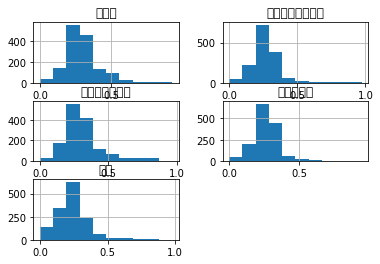

In [211]:
for idx in range(temp1.shape[1]):

In [176]:
temp0.max()

경상대         0.932679
부산복합자재창고    0.971239
인천수산정수장     0.967599
하동보건소       0.947981
신안          0.977688
dtype: float64

array([[ 1.76197767,  0.47682683,  1.14424528,  0.88829548,  1.20433409],
       [ 1.90052495,  0.56337476,  0.71671605,  0.89191287,  1.06298134],
       [ 1.82313445,  0.68175079,  2.04224869,  0.98466568,  1.42305879],
       ...,
       [ 0.43964083,  0.75048409, -1.38765732,  0.56800051, -1.37395112],
       [ 0.59220939,  0.42247198,  0.57127079,  0.5127219 ,  2.31136777],
       [ 0.45348232,  0.43275758,  0.58762693,  1.16649298, -1.93981498]])

(array([1.453e+03, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

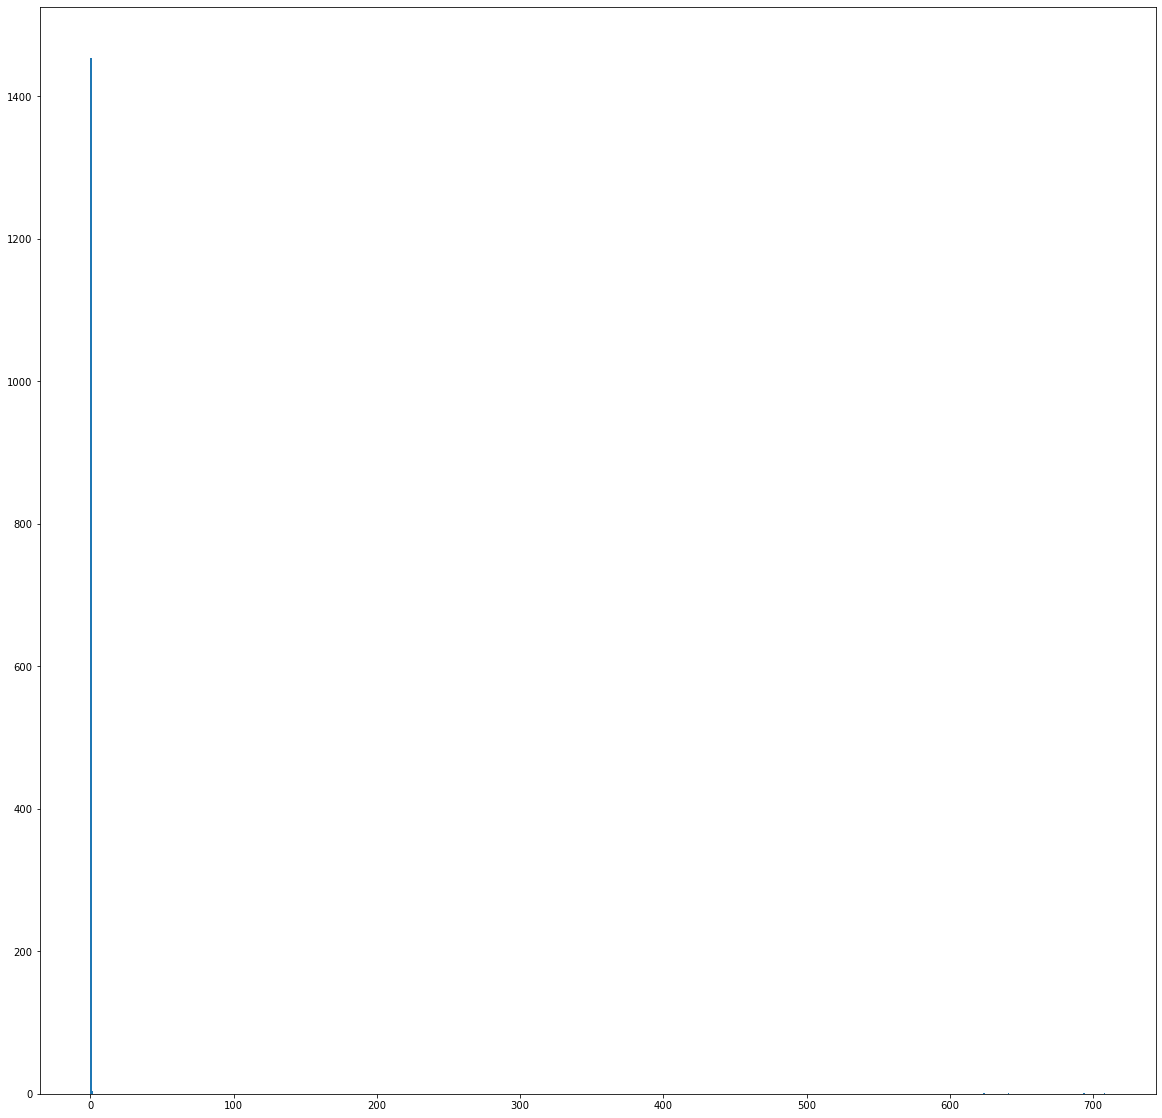

In [196]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,20))
plt.hist(temp0.iloc[:,0], bins=750)

In [19]:
f = open('./dataset/features/others/total_area_2017_2020_일사(MJ__m2).csv', mode='r', encoding='cp949')

In [8]:
ray_dataset

,����,�����׼���,����.1,��������_������,����.2,��õ,�����ּҳ�,�λ꺹������â��,�λ꺹��1�ܰ�,�λ��ó����,...,�����Ÿ���_�۾�,��������â��,����.4,����ȯ������,Ȳ�ݹ�������,��������⹰�Ÿ���,����������,���Ͽ�����b,�뱸,�ž�
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
solar_dataset

,경상대,광양항세방,구미,남동발전_본사사옥,영동,예천,남제주소내,부산복합자재창고,부산복합1단계,부산수처리장,...,당진매립장_송악,당진자재창고,동해,수원환경사업소,황금물류센터,세종시폐기물매립장,연성정수장,영암에프원b,대구,신안
0,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.0,0.0,0.0,NaN,0.321141,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
35060,0.0,0.0,0.0,NaN,0.623640,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
35061,0.0,0.0,0.0,NaN,0.649846,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
35062,0.0,0.0,0.0,NaN,0.130402,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
